### Ensemble trees for kaviar
* duplicate positons are removed
* focus on cgi vs both, limit by ahmad good regions
* focus on high freq vars?

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
%matplotlib inline

def write_feature_importance(
    X, indices, cols, importances, std,
):
    for f in range(X.shape[1]):
        ls = (
            cols[indices[f]],
            importances[indices[f]],
            std[indices[f]],
        )
        print("%s\t%f\t%f" % ls)

/opt/conda/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
kaviar_mat_file = '/mnt/isilon/cbmi/variome/perry/brian/explore-cgi/data/interim/kaviar.mat'
dat = pd.read_csv(kaviar_mat_file, sep='\t')

/opt/conda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# limit to not rare
#dat = dat[dat.af<2**-14]
features = [x for x in dat.columns if not x in ('kaviar_status', 'var_type', 'chrom', 'pos', 'ref', 'alt', 'af')]
dat = dat.drop_duplicates(subset=['chrom', 'pos'])

In [4]:
#dat_cgi = dat[((dat['ahmad_status'] == 1) | (dat['ahmad_status'] == 0)) & ((dat.kaviar_status=='cgi') | (dat.kaviar_status=='both'))]
dat_cgi = dat[(dat['ahmad_status'] == 1) & ((dat.kaviar_status=='cgi') | (dat.kaviar_status=='both'))]
dat_cgi.loc[:, 'y'] = dat_cgi.apply(lambda row: 1 if row['kaviar_status'] == 'both' else 0, axis=1)
dat_cgi.groupby('y').size()

/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


y
0    132486
1    173234
dtype: int64

In [5]:
#dat_cgi = dat[((dat['ahmad_status'] == 1) | (dat['ahmad_status'] == 0)) & ((dat.kaviar_status=='cgi') | (dat.kaviar_status=='both'))]
#dat_cgi.loc[:, 'y'] = dat_cgi.apply(lambda row: 1 if row['kaviar_status'] == 'both' else 0, axis=1)

pos_cgi = dat_cgi[dat_cgi.y==1].sample(132400)
neg_cgi = dat_cgi[dat_cgi.y==0].sample(132400)
dat_cgi = pd.concat([pos_cgi, neg_cgi])

X = dat_cgi[features].values
X = StandardScaler().fit_transform(X)
y = dat_cgi['y'].values

rfc = RandomForestClassifier(n_estimators=200)
clf = svm.SVC(kernel='poly', C=1)
clf_tree = tree.DecisionTreeClassifier(max_depth=2)
scores = cross_val_score(rfc, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

dat_cgi.groupby('kaviar_status').size()

/opt/conda/lib/python3.4/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Accuracy: 0.62 (+/- 0.01)


kaviar_status
both    132400
cgi     132400
dtype: int64

In [6]:
cols = features
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
write_feature_importance(
    X, indices, cols, importances, std
)

AllRepeats_gt95percidentity_slop5	0.201267	0.196119
rmsk	0.179846	0.184602
AllRepeats_lt51bp_gt95identity_merged	0.130167	0.166431
1kg	0.115642	0.104733
20120824_combined_mask	0.111571	0.105693
notinAllRepeats_gt95percidentity_slop5	0.058489	0.039804
simpleRepeat	0.037534	0.052688
notinrefseq_union_cds.sort	0.035076	0.038878
human_g1k_v37_l100_gc30to55_slop50	0.028916	0.058171
human_g1k_v37_l100_gclt30orgt55_slop50	0.022474	0.023488
dgv.short	0.018386	0.003762
dgv	0.010677	0.005988
GRCh37GenomicSuperDup.sorted	0.008034	0.002158
hg19_self_chain_split.sort	0.006311	0.001366
lowmappabilityall	0.006290	0.011000
siren_similarRegions_dist1	0.006227	0.012966
notinlowmappabilityall	0.006072	0.014783
hg19_self_chain_split_both	0.005915	0.002079
notinsegdupall	0.005313	0.008114
segdupall	0.003617	0.004359
BadPromoters_gb-2013-14-5-r51-s1	0.002063	0.001316
blackTerry	0.000114	0.000046
hg19.blacklist	0.000000	0.000000
ahmad_status	0.000000	0.000000


[  2.25704580e-01   1.46278703e-01   1.21345561e-01   8.04157285e-02
   6.47730852e-02   5.50168451e-02   5.00446130e-02   4.53376172e-02
   4.47924312e-02   3.78889566e-02   2.90322290e-02   2.77919191e-02
   2.52239583e-02   1.28953291e-02   1.22552076e-02   9.44051821e-03
   4.45810710e-03   2.95553688e-03   2.74361122e-03   1.27488577e-03
   3.30576561e-04   7.25997354e-35   1.31023095e-42   0.00000000e+00]


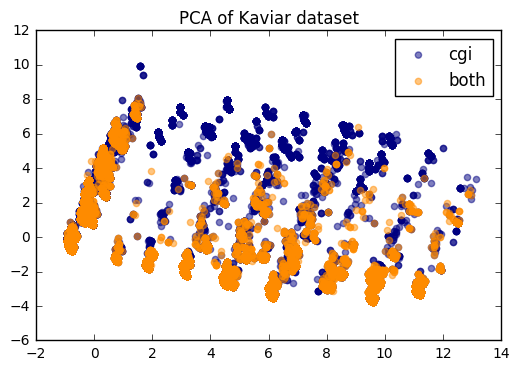

In [10]:
pca = PCA()
X_r = pca.fit(X).transform(X)

#lda = LinearDiscriminantAnalysis()
#X_r2 = lda.fit(X, y).transform(X)

print(pca.explained_variance_ratio_)

plt.figure()
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], ['cgi', 'both']):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], alpha=.5, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Kaviar dataset')

plt.show()